In [1]:
import cc3d
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw, measure
from shapely.geometry import Polygon

from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import os

## Functions

In [2]:
from typing import Dict

def roi_matching(original_roi: Polygon, roi_to_compare: Polygon, roi_to_compare_id: int, results: Dict, plane_indicator: str) -> Dict:
    
        tmp_roi = Polygon(tmp_contours)

        iou = original_roi.intersection(roi_to_compare).area / original_roi.union(roi_to_compare).area
        proportion = original_roi.intersection(roi_to_compare).area / original_roi.area

        if original_roi.within(roi_to_compare) or roi_to_compare.within(original_roi): within = True
        else: within = False

        results[f'matching_ids_{plane_indicator}_plane'].append(roi_to_compare_id)
        results[f'full_overlap_{plane_indicator}_plane'].append(within)
        results[f'overlapping_area_{plane_indicator}_plane'].append(proportion)
        results[f'IoUs_{plane_indicator}_plane'].append(iou)
        
        return results
    

In [3]:
def find_best_matches(results: Dict) -> Dict:
    
    for plane_indicator in ['previous', 'next']:
        if len(results[f'matching_ids_{plane_indicator}_plane']) > 0:
            max_iou = max(results[f'IoUs_{plane_indicator}_plane'])
            if max_iou >= 0.5: # Does this really make sense here? IoU could also be < 0.5 and within == False, but only because of some pixel? Max reciprocal overlap??
                index = results[f'IoUs_{plane_indicator}_plane'].index(max_iou)
            elif any(results[f'full_overlap_{plane_indicator}_plane']):
                index = results[f'full_overlap_{plane_indicator}_plane'].index(True)
            else:
                index = None
            
            if type(index) == int:
                best_matching_id = results[f'matching_ids_{plane_indicator}_plane'][index]
                iou = max_iou
                overlap = results[f'overlapping_area_{plane_indicator}_plane'][index]
            else: 
                best_matching_id, iou, overlap = None, None, None
                
            results[f'best_match_{plane_indicator}_plane'] = best_matching_id
            results[f'overlapping_area_best_match_{plane_indicator}_plane'] = overlap
            results[f'IoU_best_match_{plane_indicator}_plane'] = iou
    
    return results
            
            
            
        
        
    

In [4]:
def trace_matches(matching_results, final_ids_assignment, current_final_id, current_plane_idx, current_plane_label_id):
    best_match_next_plane = matching_results[current_plane_idx][current_plane_label_id]['best_match_next_plane']
    next_plane_idx = current_plane_idx + 1

    if matching_results[next_plane_idx][best_match_next_plane]['final_label_id_assigned']:
        raise ValueError(f'ROI with ID {best_match_next_plane} in plane {next_plane_idx} was already assigned! :o')
    else:
        if matching_results[next_plane_idx][best_match_next_plane]['best_match_previous_plane'] != current_plane_label_id:
            raise ValueError(f'ROI with ID {best_match_next_plane} in plane {next_plane_idx} does not share best matching with previous plane!')
        else:
            matching_results[next_plane_idx][best_match_next_plane]['final_label_id_assigned'] = True
            matching_results[next_plane_idx][best_match_next_plane]['final_label_id'] = current_final_id
            final_ids_assignment[current_final_id]['plane_index'].append(next_plane_idx)
            final_ids_assignment[current_final_id]['original_label_id'].append(best_match_next_plane)

            if matching_results[next_plane_idx][best_match_next_plane]['best_match_next_plane'] != None:
                keep_tracing = True
                
            else:
                keep_tracing = False

    return matching_results, final_ids_assignment, keep_tracing

In [5]:
def unpad_x_y_dims_in_2d_array(padded_2d_array, pad_width):
    return padded_2d_array[pad_width:padded_2d_array.shape[0]-pad_width, pad_width:padded_2d_array.shape[1]-pad_width]
    
    
def unpad_x_y_dims_in_3d_array(padded_3d_array, pad_width):
    return padded_3d_array[:, pad_width:padded_3d_array.shape[1]-pad_width, pad_width:padded_3d_array.shape[2]-pad_width]

# Create some dummy data to develop & test first ideas

In [6]:
plane_0 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
                    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

plane_1 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
                    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

plane_2 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
                    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

plane_3 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    [0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
                    [0, 1, 1, 0, 0, 0, 0, 0, 1, 0]])

plane_4 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])



In [7]:
instseg_plane_0 = np.array([[1, 1, 2, 2, 0, 0, 0, 0, 0, 0], 
                            [1, 1, 2, 2, 0, 0, 0, 0, 0, 0],
                            [1, 1, 2, 2, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

instseg_plane_1 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
                            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

instseg_plane_2 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
                            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
                            [0, 0, 0, 0, 0, 0, 0, 3, 3, 3],
                            [0, 0, 0, 0, 0, 0, 0, 0, 3, 0]])

instseg_plane_3 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                            [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
                            [0, 3, 3, 0, 0, 0, 0, 2, 2, 2],
                            [0, 3, 3, 0, 0, 0, 0, 0, 2, 0]])

instseg_plane_4 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])



In [8]:
instseg_plane_0 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
                            [1, 1, 1, 2, 2, 0, 0, 0, 0, 0],
                            [1, 1, 2, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 2, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

instseg_plane_1 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
                            [1, 1, 1, 2, 2, 2, 0, 0, 0, 0],
                            [1, 1, 1, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 3, 2, 3, 0, 0, 0, 0],
                            [0, 0, 0, 3, 3, 3, 0, 0, 0, 0],
                            [0, 0, 0, 3, 3, 3, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

instseg_plane_2 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
                            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
                            [0, 0, 0, 0, 0, 0, 0, 3, 3, 3],
                            [0, 0, 0, 0, 0, 0, 0, 0, 3, 0]])

instseg_plane_3 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                            [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
                            [0, 3, 3, 0, 0, 0, 0, 2, 2, 2],
                            [0, 3, 3, 0, 0, 0, 0, 0, 2, 0]])

instseg_plane_4 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])



In [9]:
zstack = np.array([plane_0, plane_1, plane_2, plane_3, plane_4])
instseg_zstack = np.array([instseg_plane_0, instseg_plane_1, instseg_plane_2, instseg_plane_3, instseg_plane_4])
labels_out_zstack, N_cc_zstack = cc3d.connected_components(zstack, return_N = True)
labels_out_instseg_zstack, N_cc_instseg_zstack = cc3d.connected_components(instseg_zstack, return_N = True)


In [10]:
N_cc_instseg_zstack

8

In [11]:
instseg_zstack

array([[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 2, 2, 0, 0, 0, 0, 0],
        [1, 1, 2, 2, 2, 2, 0, 0, 0, 0],
        [0, 0, 2, 2, 2, 2, 0, 0, 0, 0],
        [0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 2, 2, 2, 0, 0, 0, 0],
        [1, 1, 1, 2, 2, 2, 0, 0, 0, 0],
        [0, 0, 0, 2, 2, 2, 0, 0, 0, 0],
        [0, 0, 0, 3, 2, 3, 0, 0, 0, 0],
        [0, 0, 0, 3, 3, 3, 0, 0, 0, 0],
        [0, 0, 0, 3, 3, 3, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 2, 2, 0, 0, 0, 

# Load actual instance segmented data

In [12]:
import os

path = '/mnt/c/Users/dsege/TEMP/test_project2/05_instance_segmentations/'
cellpose_preds = [filename for filename in os.listdir(path) if filename.startswith('0000')]

cellpose_preds_to_stack = list()
for single_plane in cellpose_preds:
    cellpose_preds_to_stack.append(plt.imread(path + single_plane))
    
cellpose_pred_zstack = np.asarray(cellpose_preds_to_stack)

In [13]:
np.unique(cellpose_pred_zstack[5])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92], dtype=uint16)

In [14]:
pad_width = 1

padded_zstack = cellpose_pred_zstack.copy()
padded_zstack = np.pad(padded_zstack, pad_width=pad_width, mode = 'constant', constant_values = 0)
padded_zstack = padded_zstack[pad_width:padded_zstack.shape[0]-pad_width]


zstack = padded_zstack.copy()
z_dim, x_dim, y_dim = zstack.shape

results = dict()

for plane_idx in range(z_dim):
    print(f'starting with plane {plane_idx}')
    results[plane_idx] = dict()
    
    if plane_idx == 0:
        previous_plane_idx = None
        next_plane_idx = plane_idx + 1
    elif plane_idx == z_dim - 1:
        previous_plane_idx = plane_idx - 1
        next_plane_idx = None
    else:
        previous_plane_idx = plane_idx - 1
        next_plane_idx = plane_idx + 1
         
    plane = zstack[plane_idx]
    unique_label_ids = list(np.unique(plane))
    unique_label_ids.remove(0)

    for label_id in unique_label_ids:
        tmp_array = np.zeros((x_dim, y_dim), dtype='uint8')
        tmp_array[np.where(zstack[plane_idx] == label_id)] = 1
        tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
        roi = Polygon(tmp_contours)
        roi_area = roi.area
        
        results[plane_idx][label_id] = {'final_label_id_assigned': False,
                                        'final_label_id': None,
                                        'area': roi_area,
                                        'matching_ids_previous_plane': list(),
                                        'full_overlap_previous_plane': list(), # only relevant if best match less than 0.5 IoU threshold?
                                        'overlapping_area_previous_plane': list(),
                                        'IoUs_previous_plane': list(),
                                        'matching_ids_next_plane': list(),
                                        'full_overlap_next_plane': list(), # only relevant if best match less than 0.5 IoU threshold?
                                        'overlapping_area_next_plane': list(),
                                        'IoUs_next_plane': list(),
                                        'best_match_previous_plane': None,
                                        'overlapping_area_best_match_previous_plane': None,
                                        'IoU_best_match_previous_plane': None,
                                        'best_match_next_plane': None,
                                        'overlapping_area_best_match_next_plane': None,
                                        'IoU_best_match_next_plane': None}
        # Reset results:
        labels_of_pixels_in_previous_plane, labels_of_pixels_in_next_plane = None, None
        
        if previous_plane_idx != None:
            labels_of_pixels_in_previous_plane = zstack[previous_plane_idx][np.where(plane == label_id)]
            labels_of_pixels_in_previous_plane = list(np.unique(labels_of_pixels_in_previous_plane))
            if 0 in labels_of_pixels_in_previous_plane:
                labels_of_pixels_in_previous_plane.remove(0)
            elif 0.0 in labels_of_pixels_in_previous_plane:
                labels_of_pixels_in_previous_plane.remove(0.0)
            
            for label_id_prev_plane in labels_of_pixels_in_previous_plane:
                tmp_array = np.zeros((x_dim, y_dim), dtype='uint8')
                tmp_array[np.where(zstack[previous_plane_idx] == label_id_prev_plane)] = 1
                tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
                tmp_roi = Polygon(tmp_contours)
                
                results[plane_idx][label_id] = roi_matching(roi, tmp_roi, label_id_prev_plane, results[plane_idx][label_id], 'previous')
                
        if next_plane_idx != None:
            labels_of_pixels_in_next_plane = zstack[next_plane_idx][np.where(plane == label_id)]
            labels_of_pixels_in_next_plane = list(np.unique(labels_of_pixels_in_next_plane))
            if 0 in labels_of_pixels_in_next_plane:
                labels_of_pixels_in_next_plane.remove(0)
            elif 0.0 in labels_of_pixels_in_next_plane:
                labels_of_pixels_in_next_plane.remove(0.0)
                
            for label_id_next_plane in labels_of_pixels_in_next_plane:
                tmp_array = np.zeros((x_dim, y_dim), dtype='uint8')
                tmp_array[np.where(zstack[next_plane_idx] == label_id_next_plane)] = 1
                tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
                tmp_roi = Polygon(tmp_contours)
                
                results[plane_idx][label_id] = roi_matching(roi, tmp_roi, label_id_next_plane, results[plane_idx][label_id], 'next')            

            
        

starting with plane 0
starting with plane 1
starting with plane 2
starting with plane 3
starting with plane 4
starting with plane 5
starting with plane 6
starting with plane 7


In [15]:
for plane_id in range(z_dim):
    for label_id in results[plane_id].keys():
        results[plane_id][label_id] = find_best_matches(results[plane_id][label_id])

In [16]:
final_ids = dict()

keep_going = True
final_label_id = 2000

for plane_idx in range(z_dim):
    for label_id in results[plane_idx].keys():
        if results[plane_idx][label_id]['final_label_id_assigned']:
            continue
        else:
            final_ids[final_label_id] = {'plane_index': list(),
                                         'original_label_id': list()}
            
            results[plane_idx][label_id]['final_label_id_assigned'] = True
            results[plane_idx][label_id]['final_label_id'] = final_label_id
            final_ids[final_label_id]['plane_index'].append(plane_idx)
            final_ids[final_label_id]['original_label_id'].append(label_id)

            # Now start tracing:
            if results[plane_idx][label_id]['best_match_next_plane'] != None:

                keep_tracing = True
                while keep_tracing:
                    results, final_ids, keep_tracing = trace_matches(results, 
                                                                     final_ids, 
                                                                     final_label_id, 
                                                                     final_ids[final_label_id]['plane_index'][-1], 
                                                                     final_ids[final_label_id]['original_label_id'][-1])


            final_label_id += 1

In [17]:
final_ids

{2000: {'plane_index': [0, 1], 'original_label_id': [1, 1]},
 2001: {'plane_index': [0, 1, 2], 'original_label_id': [2, 3, 4]},
 2002: {'plane_index': [0, 1, 2, 3, 4],
  'original_label_id': [3, 5, 7, 13, 10]},
 2003: {'plane_index': [0, 1, 2], 'original_label_id': [4, 6, 8]},
 2004: {'plane_index': [0, 1, 2], 'original_label_id': [5, 10, 12]},
 2005: {'plane_index': [0, 1, 2, 3], 'original_label_id': [6, 11, 13, 18]},
 2006: {'plane_index': [0, 1, 2, 3], 'original_label_id': [7, 17, 23, 30]},
 2007: {'plane_index': [0, 1, 2, 3], 'original_label_id': [8, 21, 28, 35]},
 2008: {'plane_index': [0, 1, 2, 3, 4],
  'original_label_id': [9, 23, 30, 40, 40]},
 2009: {'plane_index': [0, 1, 2, 3, 4],
  'original_label_id': [10, 24, 33, 47, 48]},
 2010: {'plane_index': [0, 1, 2, 3, 4],
  'original_label_id': [11, 28, 37, 53, 55]},
 2011: {'plane_index': [0, 1, 2], 'original_label_id': [12, 31, 47]},
 2012: {'plane_index': [0, 1, 2, 3, 4, 5, 6],
  'original_label_id': [13, 36, 51, 62, 71, 55, 31]}

In [18]:
new_zstack = zstack.copy()

In [19]:
for final_label_id in final_ids.keys():
    for idx in range(len(final_ids[final_label_id]['plane_index'])):
        plane_index = final_ids[final_label_id]['plane_index'][idx]
        label_id = final_ids[final_label_id]['original_label_id'][idx]
        new_zstack[plane_index][np.where(new_zstack[plane_index] == label_id)] = final_label_id
        
new_zstack = unpad_x_y_dims_in_3d_array(new_zstack, pad_width)

In [16]:
labels_out_new_zstack, N_cc_new_zstack = cc3d.connected_components(new_zstack, return_N = True)

In [17]:
N_cc_new_zstack

193

In [ ]:
# select a roi in a given plane (e.g. from tracing for rois with multiple matches)

# get centroid coordinates & compute image slice to look at: +- 200 pixels from centroid x and y

# find all rois with their final_ids that are in this image slice

# assign a color to each of them

# plot one row per plane: rgb image, cellpose mask, rgb image + roi boundaries color coded, cellpose mask + roi boundaries color coded 

In [20]:
multi_matches_traceback = list()

for plane_idx in results.keys():
    for label_id in results[plane_idx].keys():
        condition_a = len(results[plane_idx][label_id]['matching_ids_next_plane']) > 1
        condition_b = len(results[plane_idx][label_id]['matching_ids_previous_plane']) > 1
        if condition_a or condition_b:
            multi_matches_traceback.append((plane_idx, label_id))

multi_matches_traceback

[(1, 7),
 (1, 29),
 (1, 36),
 (1, 44),
 (2, 4),
 (2, 6),
 (2, 30),
 (2, 53),
 (2, 65),
 (2, 66),
 (3, 14),
 (3, 40),
 (3, 58),
 (3, 62),
 (3, 72),
 (3, 73),
 (4, 39),
 (4, 66),
 (4, 71),
 (4, 81),
 (4, 85),
 (4, 91),
 (5, 26),
 (5, 53),
 (5, 69),
 (6, 27),
 (6, 42),
 (6, 43),
 (6, 46)]

In [21]:
results[5][26]

{'final_label_id_assigned': True,
 'final_label_id': 2161,
 'area': 4395.5,
 'matching_ids_previous_plane': [39, 40],
 'full_overlap_previous_plane': [False, False],
 'overlapping_area_previous_plane': [0.42918894323740187, 0.5377658969400523],
 'IoUs_previous_plane': [0.42156424581005586, 0.43147903071236254],
 'matching_ids_next_plane': [12],
 'full_overlap_next_plane': [False],
 'overlapping_area_next_plane': [0.9430098964850415],
 'IoUs_next_plane': [0.9087919315939487],
 'best_match_previous_plane': None,
 'overlapping_area_best_match_previous_plane': None,
 'IoU_best_match_previous_plane': None,
 'best_match_next_plane': 12,
 'overlapping_area_best_match_next_plane': 0.9430098964850415,
 'IoU_best_match_next_plane': 0.9087919315939487}

In [22]:
unpadded_zstack = unpad_x_y_dims_in_3d_array(zstack, 1)
z_dim, x_dim, y_dim = unpadded_zstack.shape

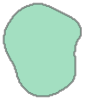

In [23]:
plane_id = 5
label_id = 26

plane = unpadded_zstack[plane_id]
tmp_array = np.zeros((x_dim, y_dim), dtype='uint8')
tmp_array[np.where(plane == label_id)] = 1
tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
tmp_roi = Polygon(tmp_contours)
tmp_roi

In [24]:
half_window_size = 200

centroid_x, centroid_y = round(tmp_roi.centroid.x), round(tmp_roi.centroid.y)

cminx, cmaxx = centroid_x - half_window_size, centroid_x + half_window_size
cminy, cmaxy = centroid_y - half_window_size, centroid_y + half_window_size

cropped_new_zstack = new_zstack.copy()
cropped_new_zstack = cropped_new_zstack[:, cminx:cmaxx, cminy:cmaxy]

cropped_z_dim, cropped_x_dim, cropped_y_dim = cropped_new_zstack.shape

In [36]:
from matplotlib.pyplot import cm

label_ids = list(np.unique(cropped_new_zstack))
if 0 in label_ids:
    label_ids.remove(0)
    
n_label_ids = len(label_ids)
colormixer = cm.rainbow(np.linspace(0, 1, n_label_ids))

color_code = dict()
for idx in range(n_label_ids):
    color_code[label_ids[idx]] = colormixer[idx]

plotting_info = dict()
for plane_index in range(cropped_z_dim):
    plotting_info[plane_index] = dict()
    


for label_id in label_ids:
    for plane_index in final_ids[label_id]['plane_index']:
        plane = cropped_new_zstack[plane_index]
        if label_id in np.unique(cropped_new_zstack[plane_index]):
            tmp_array = np.zeros((cropped_x_dim, cropped_y_dim), dtype='uint8')
            tmp_array[np.where(plane == label_id)] = 1
            tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
            tmp_roi = Polygon(tmp_contours)
            boundary_x_coords, boundary_y_coords = np.asarray(tmp_roi.boundary.xy[0]), np.asarray(tmp_roi.boundary.xy[1])
            plotting_info[plane_index][label_id] = {'color': color_code[label_id],
                                                    'boundary_x_coords': boundary_x_coords,
                                                    'boundary_y_coords': boundary_y_coords}    

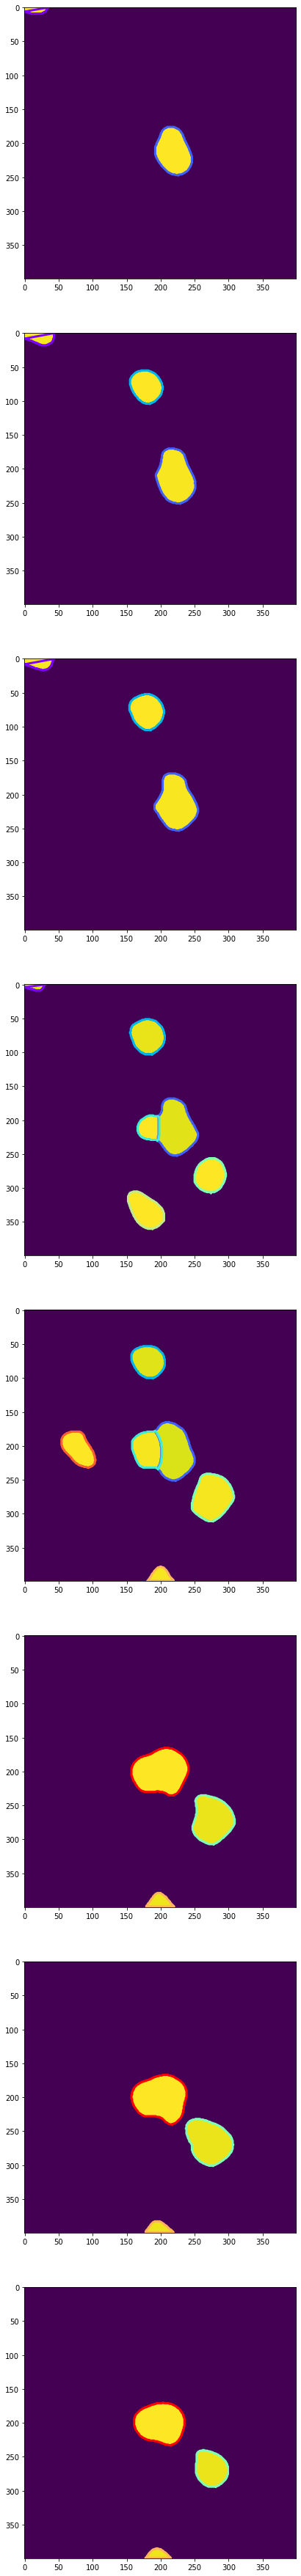

In [61]:
fig = plt.figure(figsize=(20, 5*cropped_z_dim), facecolor='white')
gs = fig.add_gridspec(cropped_z_dim, 1)







for plane_index in range(cropped_z_dim):
    fig.add_subplot(gs[plane_index, 0])
    plt.imshow(cropped_new_zstack[plane_index])
    for label_id in plotting_info[plane_index].keys():
        plt.plot(plotting_info[plane_index][label_id]['boundary_y_coords'], 
                 plotting_info[plane_index][label_id]['boundary_x_coords'], 
                 c=plotting_info[plane_index][label_id]['color'], 
                 lw=3)
plt.show()    

# Caution: This seems to be too much for the RAM to handle!

In [ ]:
from matplotlib.image import imread

file_id = '0000'

preprocessed_path = '/mnt/c/Users/dsege/TEMP/test_project2/03_preprocessed_images/'
preprocessed_filenames = [filename for filename in os.listdir(preprocessed_path) if filename.startswith(file_id)]

preprocessed_zstack = list()
for single_plane in preprocessed_filenames:
    preprocessed_zstack.append(imread(preprocessed_path + single_plane))
    
preprocessed_zstack = np.asarray(preprocessed_zstack)
preprocessed_zstack = preprocessed_zstack[:, cminx:cmaxx, cminy:cmaxy]

    
instance_mask_path = '/mnt/c/Users/dsege/TEMP/test_project2/05_instance_segmentations/'
instance_mask_filenames = [filename for filename in os.listdir(instance_mask_path) if filename.startswith(file_id)]

instance_mask_zstack = list()
for single_plane in instance_mask_filenames:
    instance_mask_zstack.append(imread(instance_mask_path + single_plane))
    
instance_mask_zstack = np.asarray(instance_mask_zstack)
instance_mask_zstack = instance_mask_zstack[:, cminx:cmaxx, cminy:cmaxy]

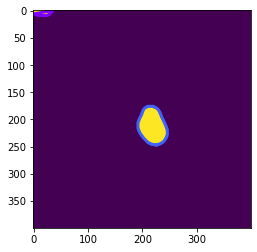

In [48]:
plt.imshow(cropped_new_zstack[0])
plt.plot(plotting_info[0][2007]['boundary_y_coords'], plotting_info[0][2007]['boundary_x_coords'], c=plotting_info[0][2007]['color'], lw=3)
plt.plot(plotting_info[0][2008]['boundary_y_coords'], plotting_info[0][2008]['boundary_x_coords'], c=plotting_info[0][2008]['color'], lw=3)

plt.show()

In [35]:
2103 in np.unique(cropped_new_zstack[plane_index])

False

In [34]:
final_ids[2103]['plane_index']

[3, 4, 5, 6, 7]

In [ ]:
n_label_ids = len(label_ids)
colormixer = cm.rainbow(np.linspace(0, 1, n_label_ids))

color_code = dict()
for idx in range(n_label_ids):
    color_code[label_ids[idx]] = colormixer[idx]
    
color_code

In [ ]:
from matplotlib.image import imread

file_id = '0000'

preprocessed_path = '/mnt/c/Users/dsege/TEMP/test_project2/03_preprocessed_images/'
preprocessed_filenames = [filename for filename in os.listdir(preprocessed_path) if filename.startswith(file_id)]

preprocessed_zstack = list()
for single_plane in preprocessed_filenames:
    preprocessed_zstack.append(imread(preprocessed_path + single_plane))
    
preprocessed_zstack = np.asarray(preprocessed_zstack)
preprocessed_zstack = preprocessed_zstack[:, cminx:cmaxx, cminy:cmaxy]

    
instance_mask_path = '/mnt/c/Users/dsege/TEMP/test_project2/05_instance_segmentations/'
instance_mask_filenames = [filename for filename in os.listdir(instance_mask_path) if filename.startswith(file_id)]

instance_mask_zstack = list()
for single_plane in instance_mask_filenames:
    instance_mask_zstack.append(imread(instance_mask_path + single_plane))
    
instance_mask_zstack = np.asarray(instance_mask_zstack)
instance_mask_zstack = instance_mask_zstack[:, cminx:cmaxx, cminy:cmaxy]

In [ ]:
cropped_zstack



In [79]:
color[0]

array([0.5, 0. , 1. , 1. ])

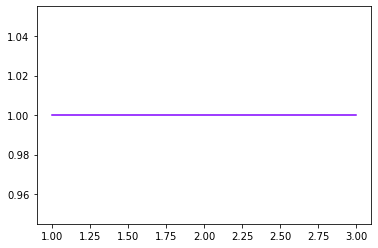

In [83]:
plt.plot([1, 2, 3], [1, 1, 1], color=color_code[2007])
plt.show()

In [30]:
np.unique(unpadded_zstack[5])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92], dtype=uint16)

In [ ]:
from matplotlib.image import imread

(8, 7600, 4628)

In [220]:
cellpose_pred_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [222]:
plane = cellpose_pred_image

x_dim, y_dim = plane.shape

In [223]:
np.unique(cellpose_pred_image)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92], dtype=uint16)

In [224]:
tmp_array = np.zeros((x_dim, y_dim), dtype='uint8')
tmp_array[np.where(plane == 26)] = 1
tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
tmp_roi = Polygon(tmp_contours)

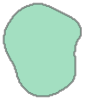

In [225]:
tmp_roi

In [226]:
round(tmp_roi.centroid.x)

4201

In [227]:
centroid_x, centroid_y = round(tmp_roi.centroid.x), round(tmp_roi.centroid.y)

In [228]:
cminx, cmaxx = centroid_x - 150, centroid_x + 150
cminy, cmaxy = centroid_y - 150, centroid_y + 150

In [235]:
cminx

4051

In [219]:
cellpose_pred_image = imread(path + cellpose_preds[5])
#cellpose_pred_image = cellpose_pred_image[2500:5000, 1500:3000]


In [236]:
boundary_x_coords, boundary_y_coords = np.asarray(tmp_roi.boundary.xy[0]) - cminx, np.asarray(tmp_roi.boundary.xy[1]) - cminy

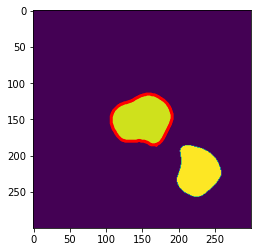

In [241]:
plt.imshow(cellpose_pred_image[cminx:cmaxx, cminy:cmaxy])
plt.plot(boundary_y_coords, boundary_x_coords, c='red', lw=3)

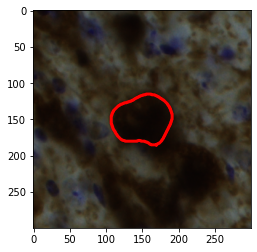

In [243]:
plt.imshow(preprocessed_image[cminx:cmaxx, cminy:cmaxy])
plt.plot(boundary_y_coords, boundary_x_coords, c='red', lw=3)

In [215]:
np.asarray(tmp_roi.boundary.xy[1]) - 500

array([446., 445., 444., 443., 442., 441., 440., 439., 438., 437., 436.,
       435., 434., 433., 432., 431., 430., 429., 428., 427., 426., 425.,
       424., 423., 422., 421., 420., 419., 418., 417., 416., 415., 414.,
       413., 412., 411., 410., 409., 408., 407., 406., 405., 404., 403.,
       402., 401., 400., 399., 398., 397., 396., 395., 394., 393., 392.,
       392., 391., 390., 390., 389., 389., 388., 387., 387., 386., 386.,
       386., 385., 385., 385., 384., 384., 384., 384., 384., 384., 384.,
       384., 384., 384., 384., 384., 385., 385., 385., 386., 386., 387.,
       387., 388., 389., 390., 391., 392., 393., 394., 395., 396., 397.,
       398., 399., 400., 401., 402., 403., 404., 405., 406., 407., 408.,
       409., 410., 411., 412., 413., 414., 415., 416., 417., 418., 419.,
       420., 421., 422., 423., 424., 425., 426., 427., 428., 429., 430.,
       431., 432., 433., 434., 435., 436., 437., 438., 439., 440., 441.,
       442., 443., 444., 445., 446., 447., 448., 44

In [158]:
path

'/mnt/c/Users/dsege/TEMP/test_project2/05_instance_segmentations/'

In [159]:
cellpose_preds[5]

'0000-005.png_class1.tif'

In [144]:
file_id = '0000'

In [145]:
preprocessed_path = '/mnt/c/Users/dsege/TEMP/test_project2/03_preprocessed_images/'
preprocessed_filenames = [filename for filename in os.listdir(preprocessed_path) if filename.startswith(file_id)]

preprocessed_filenames

['0000-000.png',
 '0000-001.png',
 '0000-002.png',
 '0000-003.png',
 '0000-004.png',
 '0000-005.png',
 '0000-006.png',
 '0000-007.png']

In [152]:
from matplotlib.image import imread

In [242]:
preprocessed_image = imread(preprocessed_path + preprocessed_filenames[5])
type(preprocessed_image)

numpy.ndarray

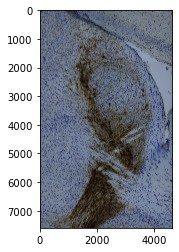

In [157]:
plt.imshow(preprocessed_image)

In [151]:
preprocessed_image = Image.open(preprocessed_path + preprocessed_filenames[5], mode='RGB')
preprocessed_image = np.asarray(preprocessed_image)

ValueError: bad mode 'RGB'

In [149]:
preprocessed_image.shape

(7598, 4626, 3)

In [150]:
plt.show(preprocessed_image)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

TypeError: Image data of dtype <U87 cannot be converted to float

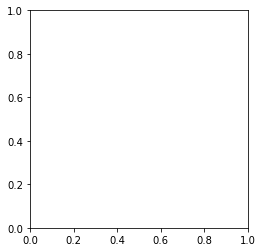

In [138]:
plt.imshow(path + cellpose_preds[5])

In [117]:
minx, miny, maxx, maxy = tmp_roi.bounds

In [119]:
miny

884.0

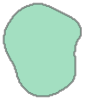

In [120]:
plane = new_zstack[5]

x_dim, y_dim = plane.shape

tmp_array = np.zeros((x_dim, y_dim), dtype='uint8')
tmp_array[np.where(plane == 2059)] = 1
tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
tmp_roi = Polygon(tmp_contours)

tmp_roi

In [122]:
tmp_roi.bounds

(1666.0, 883.0, 1736.0, 967.0)

In [123]:
zstack.shape

(8, 2502, 1502)

In [87]:
results[0][5]

{'final_label_id_assigned': True,
 'final_label_id': 2000,
 'area': 3326.5,
 'matching_ids_previous_plane': [],
 'full_overlap_previous_plane': [],
 'overlapping_area_previous_plane': [],
 'IoUs_previous_plane': [],
 'matching_ids_next_plane': [10],
 'full_overlap_next_plane': [False],
 'overlapping_area_next_plane': [0.9984969186833008],
 'IoUs_next_plane': [0.9117485588800439],
 'best_match_previous_plane': None,
 'overlapping_area_best_match_previous_plane': None,
 'IoU_best_match_previous_plane': None,
 'best_match_next_plane': 10,
 'overlapping_area_best_match_next_plane': 0.9984969186833008,
 'IoU_best_match_next_plane': 0.9117485588800439}

In [88]:
results[1][10]

{'final_label_id_assigned': True,
 'final_label_id': 2000,
 'area': 3638.0,
 'matching_ids_previous_plane': [5],
 'full_overlap_previous_plane': [False],
 'overlapping_area_previous_plane': [0.913001649257834],
 'IoUs_previous_plane': [0.9117485588800439],
 'matching_ids_next_plane': [12],
 'full_overlap_next_plane': [False],
 'overlapping_area_next_plane': [0.6668499175371083],
 'IoUs_next_plane': [0.6639299397920088],
 'best_match_previous_plane': 5,
 'overlapping_area_best_match_previous_plane': 0.913001649257834,
 'IoU_best_match_previous_plane': 0.9117485588800439,
 'best_match_next_plane': 12,
 'overlapping_area_best_match_next_plane': 0.6668499175371083,
 'IoU_best_match_next_plane': 0.6639299397920088}

In [89]:
results[2][12]

{'final_label_id_assigned': True,
 'final_label_id': 2000,
 'area': 2442.0,
 'matching_ids_previous_plane': [10],
 'full_overlap_previous_plane': [False],
 'overlapping_area_previous_plane': [0.9934479934479934],
 'IoUs_previous_plane': [0.6639299397920088],
 'matching_ids_next_plane': [],
 'full_overlap_next_plane': [],
 'overlapping_area_next_plane': [],
 'IoUs_next_plane': [],
 'best_match_previous_plane': 10,
 'overlapping_area_best_match_previous_plane': 0.9934479934479934,
 'IoU_best_match_previous_plane': 0.6639299397920088,
 'best_match_next_plane': None,
 'overlapping_area_best_match_next_plane': None,
 'IoU_best_match_next_plane': None}

In [90]:
condition_a = 3 > 1

condition_a

True

[(2, 30), (3, 40), (4, 39), (5, 26)]

In [97]:
results[5][26]

{'final_label_id_assigned': True,
 'final_label_id': 2059,
 'area': 4395.5,
 'matching_ids_previous_plane': [39, 40],
 'full_overlap_previous_plane': [False, False],
 'overlapping_area_previous_plane': [0.42918894323740187, 0.5377658969400523],
 'IoUs_previous_plane': [0.42156424581005586, 0.43147903071236254],
 'matching_ids_next_plane': [12],
 'full_overlap_next_plane': [False],
 'overlapping_area_next_plane': [0.9430098964850415],
 'IoUs_next_plane': [0.9087919315939487],
 'best_match_previous_plane': None,
 'overlapping_area_best_match_previous_plane': None,
 'IoU_best_match_previous_plane': None,
 'best_match_next_plane': 12,
 'overlapping_area_best_match_next_plane': 0.9430098964850415,
 'IoU_best_match_next_plane': 0.9087919315939487}

In [96]:
final_ids[2004]

{'plane_index': [0, 1, 2, 3, 4], 'original_label_id': [9, 23, 30, 40, 40]}

In [98]:
final_ids[2059]

{'plane_index': [5, 6, 7], 'original_label_id': [26, 12, 4]}

In [100]:
final_ids[2033]

{'plane_index': [3, 4], 'original_label_id': [39, 39]}

In [101]:
results[3][39]

{'final_label_id_assigned': True,
 'final_label_id': 2033,
 'area': 971.5,
 'matching_ids_previous_plane': [30],
 'full_overlap_previous_plane': [False],
 'overlapping_area_previous_plane': [0.11219763252702007],
 'IoUs_previous_plane': [0.0241872850327305],
 'matching_ids_next_plane': [39],
 'full_overlap_next_plane': [True],
 'overlapping_area_next_plane': [1.0],
 'IoUs_next_plane': [0.4941505595116989],
 'best_match_previous_plane': None,
 'overlapping_area_best_match_previous_plane': None,
 'IoU_best_match_previous_plane': None,
 'best_match_next_plane': 39,
 'overlapping_area_best_match_next_plane': 1.0,
 'IoU_best_match_next_plane': 0.4941505595116989}

In [99]:
results[4][39]

{'final_label_id_assigned': True,
 'final_label_id': 2033,
 'area': 1966.0,
 'matching_ids_previous_plane': [39, 40],
 'full_overlap_previous_plane': [True, False],
 'overlapping_area_previous_plane': [0.4941505595116989, 0.086088504577823],
 'IoUs_previous_plane': [0.4941505595116989, 0.03165770399812953],
 'matching_ids_next_plane': [26],
 'full_overlap_next_plane': [False],
 'overlapping_area_next_plane': [0.9595625635808749],
 'IoUs_next_plane': [0.42156424581005586],
 'best_match_previous_plane': 39,
 'overlapping_area_best_match_previous_plane': 0.4941505595116989,
 'IoU_best_match_previous_plane': 0.4941505595116989,
 'best_match_next_plane': None,
 'overlapping_area_best_match_next_plane': None,
 'IoU_best_match_next_plane': None}

In [102]:
results[5][26]

{'final_label_id_assigned': True,
 'final_label_id': 2059,
 'area': 4395.5,
 'matching_ids_previous_plane': [39, 40],
 'full_overlap_previous_plane': [False, False],
 'overlapping_area_previous_plane': [0.42918894323740187, 0.5377658969400523],
 'IoUs_previous_plane': [0.42156424581005586, 0.43147903071236254],
 'matching_ids_next_plane': [12],
 'full_overlap_next_plane': [False],
 'overlapping_area_next_plane': [0.9430098964850415],
 'IoUs_next_plane': [0.9087919315939487],
 'best_match_previous_plane': None,
 'overlapping_area_best_match_previous_plane': None,
 'IoU_best_match_previous_plane': None,
 'best_match_next_plane': 12,
 'overlapping_area_best_match_next_plane': 0.9430098964850415,
 'IoU_best_match_next_plane': 0.9087919315939487}

In [52]:
labels_out_new_zstack

array([[[1, 1, 2, 2, 0, 0, 0, 0, 0, 0],
        [1, 1, 2, 2, 0, 0, 0, 0, 0, 0],
        [1, 1, 2, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 3, 3, 0, 0, 0, 0],
        [0, 0, 0, 3, 3, 3, 0, 0, 0, 0],
        [0, 0, 0, 3, 3, 3, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 3, 3, 0, 0, 0, 